## Week 7 workshop

In this week, we'll continue to explore the GPT-style model trained on Shakespeare text.

First we import the required dependencies:

In [1]:
import sys
import torch
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from plotnine import *


sys.path.append("scratch-llm")
from model.llm import LLM
from model.tokenizer import Tokenizer
from helpers.config import LLMConfig, get_device

Next we prepare the model setup, model, and tokenizer.

In [2]:
# the model setup (has to be consistent with the trained model we're loading)
llm_config = LLMConfig(
    vocab_size = 4096,
    seq_len = 128,
    dim_emb = 256,
    num_layers = 4,
    num_heads = 8,
    emb_dropout = 0.0,
    ffn_dim_hidden = 4 * 256,
    ffn_bias = False
)

# the trained tokenizer
tokenizer = Tokenizer("data/tinyshakespeare.model")

# the model object
model = LLM(
    vocab_size = tokenizer.vocab_size,
    seq_len = llm_config.seq_len,
    dim_emb = llm_config.dim_emb,
    num_layers = llm_config.num_layers,
    attn_num_heads = llm_config.num_heads,
    emb_dropout = llm_config.emb_dropout,
    ffn_hidden_dim = llm_config.ffn_dim_hidden,
    ffn_bias = llm_config.ffn_bias
)

# the device on which we're running this (CPU vs GPU etc.)
device = get_device()

# move the model to the appropriate GPU device
model.to(device)

# load the saved model weights
model.load_state_dict(torch.load(
    "data/tinyshakespeare_llm.pt",
    weights_only = True,
    map_location = device
))

# put the model into evaluation mode
model.eval()

LLM(
  (token_embedding): Embedding(4096, 256)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (norm_attn): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (positional_encoding): RotaryPositionalEncoding()
        (proj_qkv): Linear(in_features=256, out_features=768, bias=False)
        (proj_out): Linear(in_features=256, out_features=256, bias=False)
      )
      (norm_ffn): RMSNorm()
      (feed_forward): FeedForward(
        (0): Linear(in_features=256, out_features=1024, bias=False)
        (1): SwiGLU(
          (linear): Linear(in_features=1024, out_features=2048, bias=True)
        )
        (2): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
    (1): TransformerBlock(
      (norm_attn): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (positional_encoding): RotaryPositionalEncoding()
        (proj_qkv): Linear(in_features=256, out_features=768, bias=False)
        (pro

## Helper functions

In this section we define some functions that will be used in the subsequent analysis. Skip first and then return later to read this over in detail.

First, code that can process the tiny Shakespeare text file and extract all dialog said by two specific speakers.

In [3]:
def read_dialogues(speaker1, speaker2):
    # Read file
    with open('data/tinyshakespeare.txt', 'r') as f:
        lines = f.readlines()

    speaker1_texts = []
    speaker2_texts = []
    current_speaker = None
    current_lines = []

    for line in lines:
        if line.strip().endswith(':'):
            # Save previous
            if current_speaker and current_lines:
                text = ' '.join(current_lines)
                if current_speaker == speaker1:
                    speaker1_texts.append(text)
                elif current_speaker == speaker2:
                    speaker2_texts.append(text)
        
            # New speaker
            current_speaker = line.strip().rstrip(':')
            current_lines = []
        elif current_speaker in [speaker1, speaker2] and line.strip():
            current_lines.append(line.strip())

    print(f"Speaker 1: {speaker1_texts}")
    print(f"Speaker 2: {speaker2_texts}")

    # Encode and limit to 128 tokens
    speaker1_encoded = [tokenizer.sp.encode(text)[:128] for text in speaker1_texts]
    speaker2_encoded = [tokenizer.sp.encode(text)[:128] for text in speaker2_texts]
    return speaker1_encoded, speaker2_encoded

Next, code that can classify dialogues based on mean embeddings.

In [4]:
def classify_dialogues(speaker1_encoded, speaker2_encoded, model, device='cpu', layer_index=-1, n_components=20):
    
    def get_dialogue_embedding(token_list):
        """Get embedding from specified transformer layer by averaging over sequence"""
        # Pad/truncate to sequence length
        if len(token_list) < model.seq_len:
            tokens = token_list + [0] * (model.seq_len - len(token_list))
        else:
            tokens = token_list[:model.seq_len]
        
        # Convert to tensor
        x = torch.tensor([tokens], dtype=torch.int32).to(device)
        
        # Store layer output
        layer_outputs = []
        
        def hook_fn(module, input, output):
            layer_outputs.append(output.detach().clone())
        
        # Register hook on specific layer
        hook = model.transformer[layer_index].register_forward_hook(hook_fn)
        
        # Forward pass
        with torch.no_grad():
            _ = model(x)
        
        # Clean up hook
        hook.remove()
        
        # Average over sequence length: (1, seq_len, dim_emb) -> (dim_emb,)
        embedding = layer_outputs[0].squeeze(0).mean(dim=0).cpu().numpy()
        return embedding
    
    # Extract embeddings from transformer layer
    print(f"Extracting embeddings from transformer layer {layer_index}...")
    speaker1_embeddings = [get_dialogue_embedding(tokens) for tokens in speaker1_encoded]
    speaker2_embeddings = [get_dialogue_embedding(tokens) for tokens in speaker2_encoded]
    
    # Combine all embeddings and create labels
    X = np.array(speaker1_embeddings + speaker2_embeddings)
    y = np.array([0] * len(speaker1_embeddings) + [1] * len(speaker2_embeddings))  # 0=speaker1, 1=speaker2
    
    print(f"\nTotal samples: {len(X)}")
    print(f"Original embedding dimension: {X.shape[1]}")
    print(f"Speaker 1 dialogues: {len(speaker1_embeddings)}")
    print(f"Speaker 2 dialogues: {len(speaker2_embeddings)}")
    
    # ========== PCA FOR DIMENSIONALITY REDUCTION ==========
    print(f"\nPerforming PCA with {n_components} components for classification...")
    pca_full = PCA(n_components=n_components, random_state=3953)
    X_pca = pca_full.fit_transform(X)
    
    print(f"Reduced embedding dimension: {X_pca.shape[1]}")
    print(f"Total variance explained by {n_components} components: {sum(pca_full.explained_variance_ratio_):.2%}")
    
    # Create PCA DataFrame
    pca_df = pl.DataFrame({
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'character': ['Speaker 1'] * len(speaker1_embeddings) + ['Speaker 2'] * len(speaker2_embeddings)
    })
    
    # Create PCA plot
    pca_plot = (
        ggplot(pca_df, aes(x='x', y='y', color='character', fill='character'))
        + geom_point(size=3, alpha=0.7)
        + scale_color_manual(values={'Speaker 1': '#3498db', 'Speaker 2': '#e74c3c'})
        + scale_fill_manual(values={'Speaker 1': '#3498db', 'Speaker 2': '#e74c3c'})
        + labs(
            x=f'PC1',
            y=f'PC2',
            color='Character',
            fill='Character'
        )
        + theme_minimal()
        + theme(
            figure_size=(6, 4)
        )
    )
    
    print("PCA plot created")
    
    # ========== CLASSIFICATION ON PCA COMPONENTS ==========
    # Split into train and test sets using PCA-reduced features
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, random_state=164984, stratify=y
    )
    
    print(f"\nTraining samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Feature dimension for classification: {X_train.shape[1]}")
    
    # Train logistic regression classifier on PCA components
    print(f"\nTraining classifier on {n_components} principal components...")
    clf = LogisticRegression(random_state=69424, max_iter=1000)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Evaluate performance
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"\n{'='*50}")
    print("CLASSIFICATION RESULTS (using PCA components)")
    print(f"{'='*50}")
    print(f"Training Accuracy: {train_accuracy:.2%}")
    print(f"Test Accuracy: {test_accuracy:.2%}")
    
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred, 
                                target_names=['Speaker 1', 'Speaker 2']))
    
    print("Test Set Confusion Matrix:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"                      Predicted")
    print(f"                 Speaker 1  Speaker 2")
    print(f"Actual Speaker 1       {cm[0,0]:3d}        {cm[0,1]:3d}")
    print(f"       Speaker 2       {cm[1,0]:3d}        {cm[1,1]:3d}")
    
    # Create confusion matrix visualization
    cm_df = pl.DataFrame({
        'actual': ['Speaker 1', 'Speaker 1', 'Speaker 2', 'Speaker 2'],
        'predicted': ['Speaker 1', 'Speaker 2', 'Speaker 1', 'Speaker 2'],
        'count': [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
    })
    
    cm_plot = (
        ggplot(cm_df, aes(x='predicted', y='actual', fill='count'))
        + geom_tile(color='white', size=1.5)
        + geom_text(aes(label='count'), size=20, color='white')
        + scale_fill_gradient(low='#3498db', high='#e74c3c')
        + scale_y_discrete(
            limits = ['Speaker 2', 'Speaker 1']
        )
        + labs(
            x='Predicted',
            y='Actual',
            fill='Count'
        )
        + theme_minimal()
        + theme(
            figure_size=(5, 4)
        )
    )
    
    return clf, test_accuracy, pca_plot, cm_plot, pca_full

Speaker 1: ['Is the day so young?', 'Ay me! sad hours seem long. Was that my father that went hence so fast?', 'Not having that, which, having, makes them short.', 'Out--', 'Out of her favour, where I am in love.', "Alas, that love, whose view is muffled still, Should, without eyes, see pathways to his will! Where shall we dine? O me! What fray was here? Yet tell me not, for I have heard it all. Here's much to do with hate, but more with love. Why, then, O brawling love! O loving hate! O any thing, of nothing first create! O heavy lightness! serious vanity! Mis-shapen chaos of well-seeming forms! Feather of lead, bright smoke, cold fire, sick health! Still-waking sleep, that is not what it is! This love feel I, that feel no love in this. Dost thou not laugh?", 'Good heart, at what?', "Why, such is love's transgression. Griefs of mine own lie heavy in my breast, Which thou wilt propagate, to have it prest With more of thine: this love that thou hast shown Doth add more grief to too much

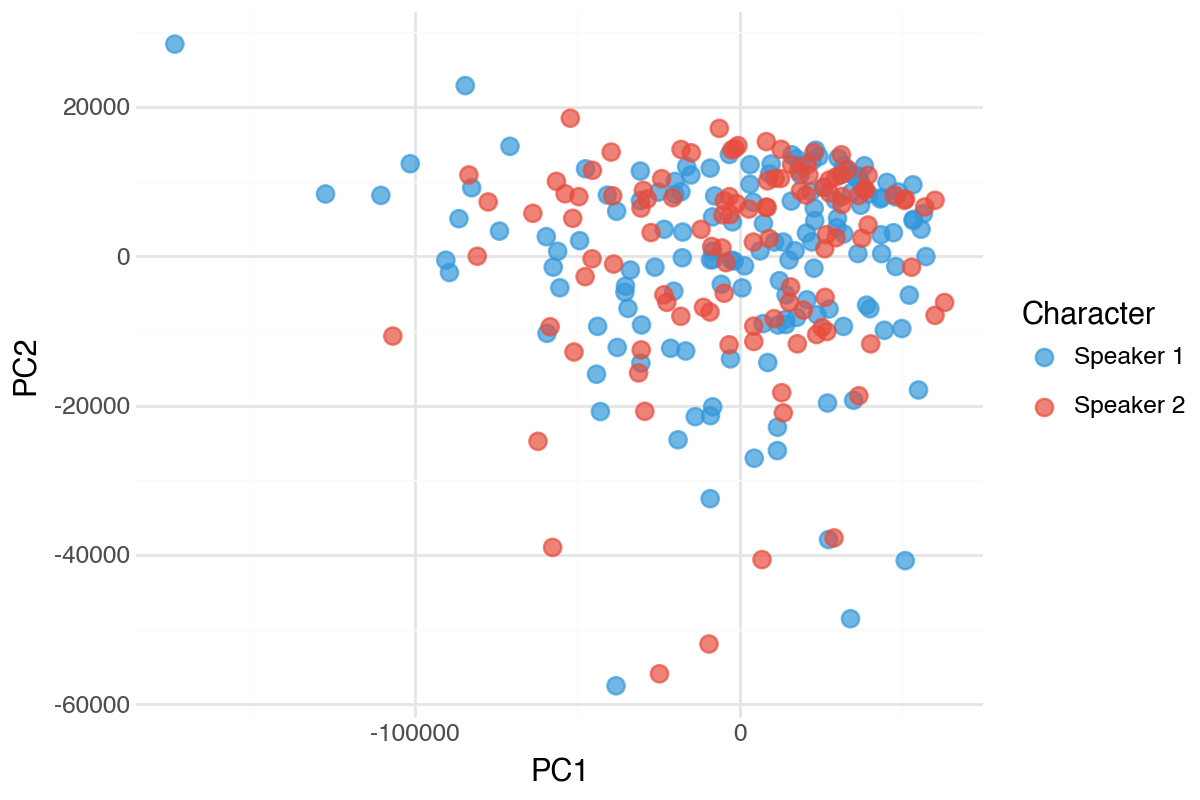


=== Confusion Matrix ===


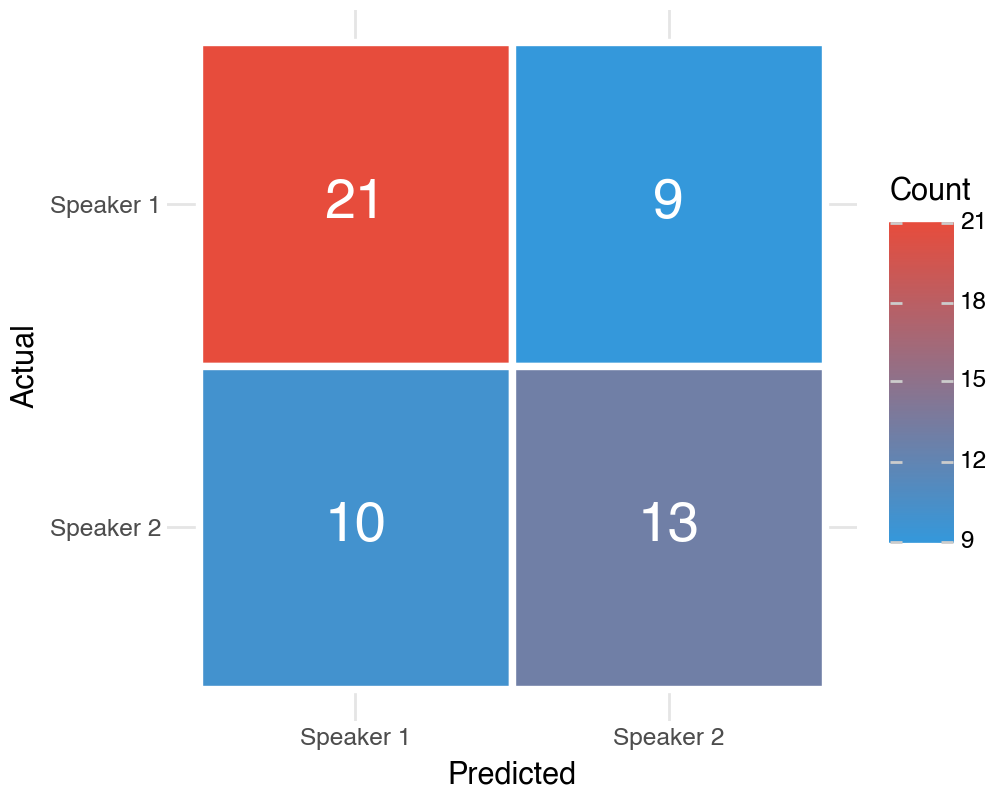

In [5]:
speaker1 = 'ROMEO'
speaker2 = 'JULIET'

# read and encode dialogues
speaker1_encoded, speaker2_encoded = read_dialogues(speaker1, speaker2)

print(f"\nSpeaker 1: {len(speaker1_encoded)} dialogues")
print(f"Speaker 2: {len(speaker2_encoded)} dialogues\n")

# classify dialogues from last layer and using first n principal components
clf, test_accuracy, pca_plot, cm_plot, pca_model = classify_dialogues(
    speaker1_encoded, 
    speaker2_encoded, 
    model, 
    device,
    layer_index = -1,  # or use 3 to explicitly specify layer 4
    n_components = 20  # use first n principal components for classification
)

print("\n=== PCA Plot ===")
pca_plot.show()

print("\n=== Confusion Matrix ===")
cm_plot.show()

## Exercises

- Change the number of components in the PCA before classification.

- Use a different random seed in the training/test split.

- Try some other speakers, for example: QUEEN ELIZABETH, KING EDWARD IV, Boy, MENENIUS, LUCIO.

- Try a different method of compressing embeddings instead of mean, for example max or min.  
  (Hint: replace `mean(dim=0)` with `max(dim=0)[0]` or `min(dim=0)[0]`, respectively. The additional index `[0]` extracts the values rather than the indices where the values are maximal or minimal.)

- Use embeddings from different layers